#Q8

#Q9

#### Load images

In [ ]:
images = [cv2.imread(f'images/{i}.jpg') for i in range(6)]

#### merge same color channels into 3 images that has 6 channels 

In [ ]:
get_all_channels = lambda imgs, chn: np.stack([img[:, :, chn] for img in imgs])

images_b = get_all_channels(images, 0)
images_g = get_all_channels(images, 1)
images_r = get_all_channels(images, 2)

#### define important functions

In [ ]:
# use an linear transformation to make the range of image into[0, 255]
def fix_numbers(channel):
    channel = channel.astype('float128')
    min_v = np.min(channel)
    max_v = np.max(channel)
    channel = (channel - min_v) * 256 // (max_v - min_v)
    return channel.astype('uint8')

def pca_fit_transform(X, n_components):
    mean = np.average(X, axis=1).reshape(-1, 1)
    std_dev = np.std(X, axis=1).reshape(-1, 1)
    X = (X - mean) / std_dev
    covariance_matrix = np.cov(X.T)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    projection_matrix = (eigen_vectors.T[:][:n_components]).T
    return_value = X @ projection_matrix
    return_value = (return_value * std_dev) + mean
    return return_value
    
# input must be channel first - output will be channel first
def use_pca_for_image(img_inp, n_components):
    img_channel_first = img_inp # the input image is already channel first
    orig_shape = img_channel_first.shape # store old size
    img_as_row = img_channel_first.reshape(orig_shape[0], -1).transpose() # make image into (n_samples, n_features) style
    new_img_as_row = pca_fit_transform(img_as_row, n_components)
    new_img = new_img_as_row.transpose().reshape(n_components , orig_shape[1], orig_shape[2])
    for idx, channel in enumerate(new_img):
        new_img[idx] = fix_numbers(channel)
    
    return new_img.astype('uint8')#.transpose([1, 2, 0])

#### calculate best mapping of each channel using pca

In [ ]:
chn_b = use_pca_for_image(images_b, 1)[0]
chn_g = use_pca_for_image(images_g, 1)[0]
chn_r = use_pca_for_image(images_r, 1)[0]

#### join all channels to create a color image

In [ ]:
merged_channels = np.stack([chn_r, chn_g, chn_b], axis=-1)

#### displaying result

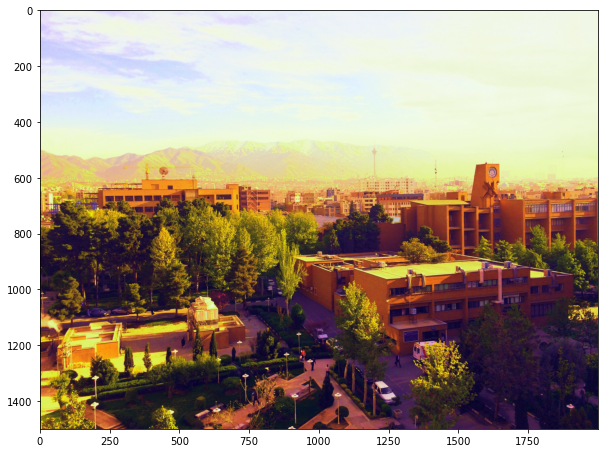

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(merged_channels)